In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output,return_layer_input
import torch
import pandas as pd
from torch.autograd import Variable

In [14]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunesamazon_hybrid.pth')

## Hybrid

### Datasets creation for hybrid

In [10]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [15]:
neg_classifier_hybrid,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model,
                                                                        hybrid_model.classifier,device=-1)

In [16]:
pos_classifier_hybrid,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier,device=-1)

In [ ]:
hybrid_model = hybrid_model.cuda()

### Negative sample analysis

In [19]:
classifier_len_hybrid = len(neg_classifier_hybrid[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))

In [20]:
from utilities_functions.ri_calculator import computeRi
negatives_ri_hybrid,neg_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,neg_classifier_hybrid,attribute_len,1)

100%|██████████| 128/128 [00:24<00:00,  5.28it/s]


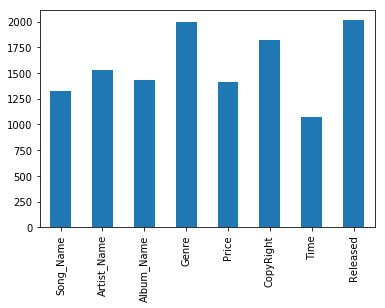

In [22]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms_hybrid,columns=attributes)
neg_variation_df.sum().plot.bar()

In [16]:
neg_variation_df.to_csv('experiments-results/exp3/negatives_ri_hybrid.csv',index=False)

## Positive samples analisys

In [17]:
positives_ri_hybrid = computeRi(hybrid_model.classifier,attributes,pos_classifier_inputs,attribute_len,0)

100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


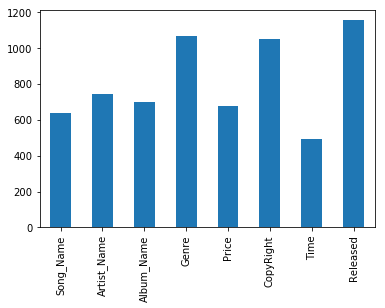

In [18]:
ri_norms_pos = []
for ri_list in positives_ri_hybrid:
    ri_norms_pos.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
pos_variation_df = pd.DataFrame(data= ri_norms_pos,columns=attributes)
pos_variation_df.sum().plot.bar()

In [19]:
pos_variation_df.to_csv('experiments-results/exp3/positives_ri_hybrid.csv',index=False)

## Rnn model Evaluation

In [33]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('../../models/itunes_amazon_rnn.pth')

### Dataset creation

In [22]:
neg_classifier_inputs_rnn,neg_ids_rnn = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,rnn_model,
                                                                        rnn_model.classifier,device=-1)

In [34]:
pos_classifier_inputs_rnn,pos_ids_rnn = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,rnn_model,
                                                                       rnn_model.classifier,device=-1)

In [35]:
rnn_model = rnn_model.cuda()

### Negative analysis

In [28]:
classifier_length = len(neg_classifier_inputs_rnn[0][0])
attribute_length = int(classifier_length/len(attributes))

In [29]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri = []
for batch in neg_classifier_inputs_rnn:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change_v1(rnn_model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:08<00:00, 15.73it/s]


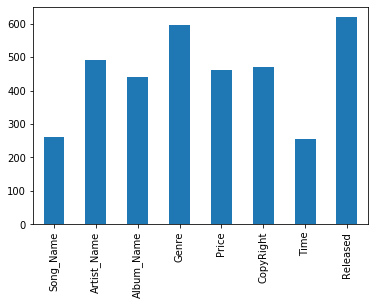

In [30]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
neg_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
neg_variation_df.sum().plot.bar()

In [38]:
neg_variation_df.to_csv('experiments-results/exp3/negatives_ri_rnn.csv',index=False)

### Positives analysis

In [36]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in pos_classifier_inputs_rnn:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change_v1(rnn_model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


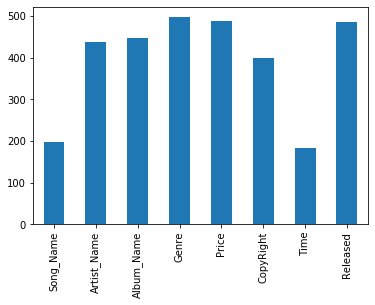

In [37]:
ri_norms_pos = []
for ri_list in positives_ri:
    ri_norms_pos.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
pos_variation_df = pd.DataFrame(data= ri_norms_pos,columns=attributes)
pos_variation_df.sum().plot.bar()

In [40]:
pos_variation_df.to_csv('experiments-results/exp3/positives_ri_rnn.csv',index=False)

## Finding closer vectors

In [20]:
from utilities_functions.distance_measures import calculate_nearest_neighbors_onAttributes

In [22]:
positives_nn = calculate_nearest_neighbors_onAttributes(pos_classifier_inputs,pos_ids,positives_ri_hybrid,
                                                       neg_classifier_inputs,neg_ids,attributes,attribute_len)

100%|██████████| 128/128 [00:00<00:00, 300.99it/s]


In [23]:
negatives_nn = calculate_nearest_neighbors_onAttributes(neg_classifier_inputs,neg_ids,negatives_ri_hybrid,
                                                        pos_classifier_inputs,pos_ids,attributes,attribute_len)

100%|██████████| 23/23 [00:00<00:00, 352.30it/s]


In [25]:
positives_nn.to_csv('experiments-results/exp3/positives_nn_hybrid.csv',index=False)
negatives_nn.to_csv('experiments-results/exp3/negatives_nn_hybrid.csv',index=False)

In [27]:
positives_nn['Price'].value_counts()

48     76
119    52
92      4
Name: Price, dtype: int64

### Compare nearest neighbours of exp.6 to near. neighbours of exp.3

In [28]:
negatives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/positives.csv')

In [ ]:
positives_nn_exp3 = pd.read_csv('experiments-results/exp3/positives_nn.csv')
negatives_nn_exp3 = pd.read_csv('experiments-results/exp3/negatives_nn.csv')
positives_nn_exp6 = pd.read_csv('experiments-results/exp6/positives_numeric_nn.csv')
negatives_nn_exp6 = pd.read_csv('experiments-results/exp6/negatives_numeric_nn.csv')

In [ ]:
nn_onAlbum_exp3 = pd.merge(positives_nn_exp3,negatives,left_on='Album_Name',right_on='id')

In [ ]:
(nn_onAlbum_exp3['ltable_Album_Name']+" | "+nn_onAlbum_exp3['rtable_Album_Name']).value_counts()

In [ ]:
nn_onAlbum_exp6 = pd.merge(positives_nn_exp6,negatives,left_on='Album_Name',right_on='id')

In [ ]:
(nn_onAlbum_exp6['ltable_Album_Name']+" | "+nn_onAlbum_exp6['rtable_Album_Name']).value_counts()

In [ ]:
negnn_onArtist_exp6 = pd.merge(negatives_nn_exp6,positives,left_on='Artist_Name',right_on='id')

In [ ]:
(negnn_onArtist_exp6['ltable_Artist_Name']+" | "+negnn_onArtist_exp6['rtable_Artist_Name']).value_counts()

In [ ]:
negnn_onArtist_exp3 = pd.merge(negatives_nn_exp3,positives,left_on='Artist_Name',right_on='id')

In [ ]:
(negnn_onArtist_exp3['ltable_Artist_Name']+" | "+negnn_onArtist_exp3['rtable_Artist_Name']).value_counts()

### Analyze nearest neighbours on artist name

In [ ]:
nn_onArtist = pd.merge(positives_closer_vectors_df,negatives,left_on='Artist_Name',right_on='id')

In [ ]:
nn_onArtist[['ltable_Artist_Name','rtable_Artist_Name']].head(30)

### Analyze nearest neighbours

In [15]:
from utilities_functions.explainer import generateExplanations

In [10]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid.pth')

In [17]:
positives_nn = pd.read_csv('experiments-results/exp3/positives_v1_nn.csv')
generateExplanations(positives_nn,10,negatives,'Price',hybrid_model,'../../Structured/itunes-amazon/positives.csv',1)


Reading and processing data from "../../Structured/itunes-amazon/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The standard true positives are 129
-------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : $ 1.29 | $ 0.69 are 126
------------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : $ 1.99 | $ 0.99 are 125
------------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Album Only | $ 1.29 are 126
------------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : $ 1.99 | $ 0.99 are 125
------------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test5.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : $ 1.29 | $ 0.69 are 126
------------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test6.csv"


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Album Only | $ 1.29 are 126
------------------


0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 6 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Album Only | $ 1.29 are 126
------------------
